In [5]:
# put the directory path to your LMR repository here
import sys
sys.path.append("/Users/dan/Desktop/LMR_py3/")
#!cd /Users/dan/Desktop/LMR_py3

# prefix for figure filename
#fig_prefix='prior_truth_'

In [6]:
import os
os.chdir('/Users/dan/Desktop/LMR_py3')
import LMR_lite_utils as LMRlite
import LMR_utils
import LMR_config
import numpy as np
import os,sys
from time import time
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.cm as cm

import seaborn as sns
import pandas as pd


Loading information from datasets.yml
Loading information from grid_def.yml


# Define routines

In [7]:
# Load and interpolate all of the priors I want to use as truth

def mk_ad(lmr_names,model_names):
    
    # Initialize an array of various interpolated model fields
    ad = []

    for ii in np.arange(len(lmr_names)):
        dd = {}
        cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
        yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
        cfg = LMRlite.load_config(yaml_file)

        X, Xb_one = LMRlite.load_prior(cfg)
        Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

        # check if config is set to regrid the prior
        if cfg.prior.regrid_method:
            print('regridding prior...')
            # this function over-writes X, even if return is given a different name
            [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
        else:
            X.trunc_state_info = X.full_state_info

        Xb_one = Xb_one_new
        Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

        dd['X']            = X
        dd['Xbp']          = Xbp
        dd['name']         = model_names[ii]
        dd['lmr_name']     = lmr_names[ii]
        dd['grid']         = LMRlite.Grid(X)
        dd['prox_manager'] = LMRlite.load_proxies(cfg)
        dd['numprox']      = len(LMRlite.load_proxies(cfg).all_proxies) 

        print(ii)
        print(dd['name'])

        ad.append(dd)
        
    return ad



In [8]:
def mk_pproxies(X,Xbp,prox_manager,SNR,grid):

    """
    Construct pseudoproxies 
    """
    
    [_,nens] = Xbp.shape

    numprox = len(prox_manager.ind_assim)

    vY = np.zeros([numprox,nens])
    vR = []
    vP = []

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon

        # Noise amplitude corresponding to SNR by stdev
        sig = np.std(Xbp[npos,:])
        #print(sig)
        #print(sig/SNR)
        # Make pproxies
        #import pdb
        #pdb.set_trace()
        randts = np.random.randn(nens,)
        randtsn = randts/np.std(randts)
        vY[proxy_idx,:] = Xbp[npos,:] + randtsn*sig/SNR
        vR.append((sig/SNR)**2)
        vP.append(proxy_idx)

    return vY, vR, vP

In [9]:
def mk_yes(X,Xbp,prox_manager,grid):
    
    [_,nens] = Xbp.shape
    numprox = len(prox_manager.ind_assim)
    vYe = np.zeros([numprox,nens])
    vYe_coords = np.zeros([numprox,2])

    for proxy_idx, Y in enumerate(prox_manager.sites_assim_proxy_objs()):
        # get grid indices
        tmp = grid.lat[:,0]-Y.lat
        itlat = np.argmin(np.abs(tmp))
        tmp = grid.lon[0,:]-Y.lon
        itlon = np.argmin(np.abs(tmp))
        npos = itlat*grid.nlon + itlon
        # the ensemble prior estimates
        vYe[proxy_idx,:] = Xbp[npos,:]
        vYe_coords[proxy_idx,:] = X.coords[npos,:]

    return vYe, vYe_coords

In [10]:
'''
ad is the dictionary of model output (all 1000 years for all)
pmi and tmi are the indices of models used for these experiments
Nensp and Nenst are the number of ensemble members used for prior and truth expectations
Nrealp and Nrealt are the number of realizations of prior and truth draws
'''
def mk_cdd(ad,pmi,tmi,Nensp,Nenst,Nrealp,Nrealt,SNR,LOCRAD):
    
    cdd = []

    for ii in np.arange(Nrealt):
        tinds = np.random.choice(1000, Nenst, replace=False)

        # First: the case where the prior is exactly the truth ens
        if (pmi==tmi and Nensp==Nenst):
            pinds              = tinds
            c                  = mk_pt(ad,pmi,tmi,SNR,LOCRAD,pinds,tinds)
            c['perfect_prior'] = True
            cdd.append(c)

        # Next: varying random draws of prior ens that are different from the truth ens
        rem   = np.setdiff1d(np.arange(1000),tinds)
        
        for jj in np.arange(Nrealp):
            remi  = np.random.choice(range(len(rem)), Nensp, replace=False)
            pinds = rem[remi]
            c     = mk_pt(ad,pmi,tmi,SNR,LOCRAD,pinds,tinds)
            c['perfect_prior'] = False
            cdd.append(c)

    print('Done!') 
    return cdd

In [11]:
def mk_pt(ad,pmi,tmi,SNR,LOCRAD,pinds,tinds):
    
    Nenst = len(tinds)
    Nensp = len(pinds)

    Xbpp  = ad[pmi]['Xbp'][:,pinds]-ad[pmi]['Xbp'][:,pinds].mean(axis=1,keepdims=True)
    Xbpt  = ad[tmi]['Xbp'][:,tinds]-ad[tmi]['Xbp'][:,tinds].mean(axis=1,keepdims=True)
    
    # Compute effective observations
    vYe, vYe_coords = mk_yes(ad[pmi]['X'],Xbpp,ad[pmi]['prox_manager'],ad[pmi]['grid'])

    # Make pseudoproxies
    vY, vR, vP = mk_pproxies(ad[tmi]['X'],Xbpt,ad[tmi]['prox_manager'],SNR,ad[tmi]['grid'])

    # Loop over ensemble members in truth. f are the reconstructions.
    fp = np.empty([ad[tmi]['grid'].nlon*ad[tmi]['grid'].nlat,Nenst])

    for kk in np.arange(Nenst):

        if LOCRAD==0.:
            # Use the optimal solver
            f,Xa,_ = LMRlite.Kalman_optimal(vY[:,kk],vR,vYe,Xbpp,verbose=False)
        else:

            # Load the config file corresponding to the iith prior
            cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
            yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
            cfg = LMRlite.load_config(yaml_file)

            # change the localization radius in the config file
            cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
            cfg_new = LMR_config.Config(**cfg_params)
            
            # Use the square root solver
            f,Xa = LMRlite.Kalman_ESRF(cfg_new,vY[:,kk],vR,vYe,Xbpp,X=ad[pmi]['X'],vYe_coords=vYe_coords,verbose=False)

        fp[:,kk]    = f

    # A few calculations...

    lat             = ad[tmi]['grid'].lat
    rmse            = np.mean((Xbpt-fp)**2,1)**.5
    gm_rmse         = np.sum(np.cos(np.deg2rad(lat.ravel()))*rmse**2)/np.sum(np.cos(np.deg2rad(lat)))

    # Store information in a dictionary for this prior-truth pair
    c = {}
    c['locrad']     = LOCRAD
    c['snr']        = SNR
    c['prior_name'] = ad[pmi]['name']
    c['truth_name'] = ad[tmi]['name']
    c['pind']       = pmi
    c['tind']       = tmi
    c['recon']      = fp
    c['rmse']       = rmse
    c['grid']       = ad[tmi]['grid']
    c['gm_rmse']    = gm_rmse
    c['tinds']      = tinds
    c['pinds']      = pinds
    c['Nensp']      = Nensp
    c['Nenst']      = Nenst

    return c

In [12]:
# Plot RMSE as a function of ensemble size
def mk_seaborn(cdd,x):

    #savename = '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_Sensitivity_locrad_0.0_snr_0.4_pmi_all_tmi_0_Nensp_300_Nenst_various_Nrealp_1_Nrealt_10'
    #cdd = np.load(savename+'.npy')

    gmp = pd.DataFrame(columns=['gm','Nensp','Nenst','prior_name','truth_name','perfect_prior'])

    for jj in np.arange(len(cdd)):

        gm = cdd[jj]['gm_rmse']
        nee = pd.DataFrame({"gm":[gm],
                            # s1.split(':')[0]
                            "prior_name":cdd[jj]['prior_name'].split('_')[0],
                            "truth_name":cdd[jj]['truth_name'].split('_')[0],
                            "Nensp":len(cdd[jj]['pinds']),
                            "Nenst":len(cdd[jj]['tinds']),
                            "perfect_prior":cdd[jj]['perfect_prior']
                           })
        if cdd[jj]['perfect_prior']:
            nee['prior_name']='perfect'
        #print(cdd[jj]['prior_name'])
        gmp=gmp.append(nee)

    sns.set(style='ticks', context='talk')

    si = 5
    fig = plt.figure(figsize=(8,4))

    ax=sns.swarmplot(data=gmp,x=x, y="gm", hue="prior_name",size=si,marker='o',palette=["g","r", "c", "y"])
    plt.xticks(np.arange(5),['100','200','300','400','500'])
    plt.xlabel(x)
    plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[2:4], labels=['CCSM4', 'MPI-ESM','HadCM3'], bbox_to_anchor=(.97, .47), loc=2, borderaxespad=0.,frameon=False)
    plt.tight_layout
    #plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD.pdf')



# Load model output

In [11]:
# Load model output
# NB that these are all generated using the same seed (by virtue of multi_seed)
lmr_names = ['ccsm4_last_millenium.1000',
             'mpi-esm-p_last_millenium.1000',
             'hadcm3_last_millenium.1000']

model_names = ['CCSM4','MPI-ESM','HadCM3']

ad=mk_ad(lmr_names,model_names)

Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


KeyboardInterrupt: 

# Run experiments

In [ ]:
# Generate a cdd array
# Case where I am using multiple realizations of the prior and different prior ensemble numbers.

SNR       = 0.4
LOCRAD    = 0.0
tmi       = 0

Nrealp    = 10
Nrealt    = 1

#Nensp     = 100
Nenspv    = np.array([100,200,300,400,500])
#Nenspv    = np.array([100,200])

Nenst     = 300

cdd = []

pmi       = 0
for Nensp in Nenspv:
    c = mk_cdd(ad,pmi,tmi,Nensp,Nenst,Nrealp,Nrealt,SNR,LOCRAD)
    cdd.extend(c)

pmi       = 1
for Nensp in Nenspv:
    c = mk_cdd(ad,pmi,tmi,Nensp,Nenst,Nrealp,Nrealt,SNR,LOCRAD)
    cdd.extend(c)

pmi       = 2
for Nensp in Nenspv:
    c = mk_cdd(ad,pmi,tmi,Nensp,Nenst,Nrealp,Nrealt,SNR,LOCRAD)
    cdd.extend(c)

    
savename  = '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_Sensitivity_locrad_'+\
             str(LOCRAD)+ '_snr_' + str(SNR)+ '_pmi_all'+\
             '_tmi_' + str(tmi)+ '_Nensp_various' + '_Nenst_' + str(Nenst)+\
             '_Nrealp_' + str(Nrealp)+ '_Nrealt_' + str(Nrealt)

print(savename)
np.save(savename,cdd)
print('All done!')

In [ ]:
# Case where I am using different truth ensemble numbers.

SNR       = 0.4
LOCRAD    = 0.0
tmi       = 0

Nrealp    = 1
Nrealt    = 10

Nensp     = 300

Nenstv    = np.array([100,200,300,400,500])
#Nenspv    = np.array([100,200])

cdd = []

pmi       = 0
for Nenst in Nenstv:
    c = mk_cdd(ad,pmi,tmi,Nensp,Nenst,Nrealp,Nrealt,SNR,LOCRAD)
    cdd.extend(c)

pmi       = 1
for Nenst in Nenstv:
    c = mk_cdd(ad,pmi,tmi,Nensp,Nenst,Nrealp,Nrealt,SNR,LOCRAD)
    cdd.extend(c)

pmi       = 2
for Nenst in Nenstv:
    c = mk_cdd(ad,pmi,tmi,Nensp,Nenst,Nrealp,Nrealt,SNR,LOCRAD)
    cdd.extend(c)

savename  = '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_Sensitivity_locrad_'+\
             str(LOCRAD)+ '_snr_' + str(SNR)+ '_pmi_all'+\
             '_tmi_' + str(tmi)+ '_Nensp_' + str(Nensp)+ '_Nenst_various'+\
             '_Nrealp_' + str(Nrealp)+ '_Nrealt_' + str(Nrealt)
print(savename)
np.save(savename,cdd)
print('All done!')


In [26]:
# Case where I am using different truth and ensemble members

SNR       = 0.4
LOCRAD    = 0.0
tmi       = 0

Nrealp    = 3
Nrealt    = 1

#Nensp     = 300

Nenstv    = np.array([100,200,300,400,500])
#Nenspv    = np.array([100,200])

cdd = []

pmi       = 0
for Nenst in Nenstv:
    Nensp = Nenst
    c = mk_cdd(ad,pmi,tmi,Nensp,Nenst,Nrealp,Nrealt,SNR,LOCRAD)
    cdd.extend(c)

pmi       = 1
for Nenst in Nenstv:
    Nensp = Nenst
    c = mk_cdd(ad,pmi,tmi,Nensp,Nenst,Nrealp,Nrealt,SNR,LOCRAD)
    cdd.extend(c)

pmi       = 2
for Nenst in Nenstv:
    Nensp = Nenst
    c = mk_cdd(ad,pmi,tmi,Nensp,Nenst,Nrealp,Nrealt,SNR,LOCRAD)
    cdd.extend(c)

savename  = '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_Sensitivity_locrad_'+\
             str(LOCRAD)+ '_snr_' + str(SNR)+ '_pmi_all'+\
             '_tmi_' + str(tmi)+ '_Nensp_various_Nenst_various'+\
             '_Nrealp_' + str(Nrealp)+ '_Nrealt_' + str(Nrealt)
print(savename)
np.save(savename,cdd)
print('All done!')

NameError: name 'ad' is not defined

# Plot output

/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/matplotlib/legend.py:1363: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


<function matplotlib.pyplot.tight_layout(pad=1.08, h_pad=None, w_pad=None, rect=None)>

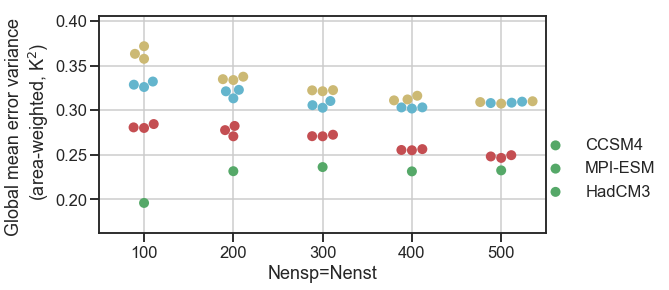

In [30]:
# Plot RMSE as a function of ensemble size

savename  = '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_Sensitivity_locrad_'+\
             str(LOCRAD)+ '_snr_' + str(SNR)+ '_pmi_all'+\
             '_tmi_' + str(tmi)+ '_Nensp_various_Nenst_various'+\
             '_Nrealp_' + str(Nrealp)+ '_Nrealt_' + str(Nrealt)

#savename = '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_Sensitivity_locrad_0.0_snr_0.4_pmi_all_tmi_0_Nensp_various_Nenst_various_Nrealp_1_Nrealt_10'
#cdd = np.load(savename+'.npy')

gmp = pd.DataFrame(columns=['gm','Nensp','Nenst','prior_name','truth_name','perfect_prior'])

for jj in np.arange(len(cdd)):
      
    gm = cdd[jj]['gm_rmse']
    nee = pd.DataFrame({"gm":[gm],
                        "prior_name":cdd[jj]['prior_name'].split('_')[0],
                        "truth_name":cdd[jj]['truth_name'].split('_')[0],
                        "Nensp":len(cdd[jj]['pinds']),
                        "Nenst":len(cdd[jj]['tinds']),
                        "perfect_prior":cdd[jj]['perfect_prior']
                       })
    if cdd[jj]['perfect_prior']:
        nee['prior_name']='perfect'
    gmp=gmp.append(nee)

sns.set(style='ticks', context='talk')

si = 10
fig = plt.figure(figsize=(8,4))

ax=sns.swarmplot(data=gmp,x="Nensp", y="gm", hue="prior_name",size=si,marker='o',palette=["g", "r","c", "y"])
#ax=sns.violinplot(data=gmp,x="Nensp", y="gm", hue="prior_name",palette=["g", "r","c", "y"])
plt.xticks(np.arange(5),['100','200','300','400','500'])
plt.xlabel('Nensp=Nenst')
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:4], labels=['CCSM4', 'MPI-ESM','HadCM3'], bbox_to_anchor=(.97, .47), loc=2, borderaxespad=0.,frameon=False)
plt.grid()
plt.tight_layout
#plt.savefig('/Users/dan/Desktop/Nullspace_Figs/evar_vs_LOCRAD.pdf')



/Users/dan/anaconda2/envs/lmr_py3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


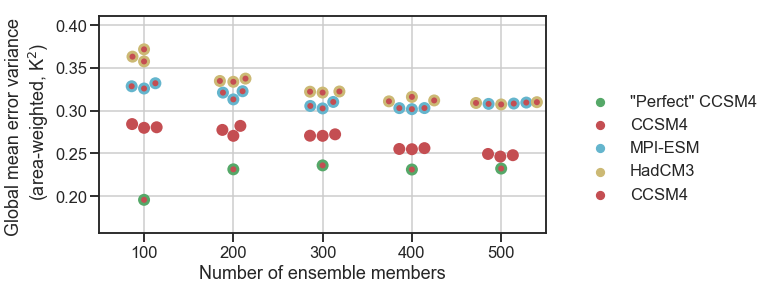

In [20]:
# Plot RMSE as a function of ensemble size

LOCRAD    = 0.0
SNR       = 0.4
tmi       = 0
Nrealp    = 3
Nrealt    = 1

savename  = '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_Sensitivity_locrad_'+\
             str(LOCRAD)+ '_snr_' + str(SNR)+ '_pmi_all'+\
             '_tmi_' + str(tmi)+ '_Nensp_various_Nenst_various'+\
             '_Nrealp_' + str(Nrealp)+ '_Nrealt_' + str(Nrealt)

#savename = '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_Sensitivity_locrad_0.0_snr_0.4_pmi_all_tmi_0_Nensp_various_Nenst_various_Nrealp_1_Nrealt_10'
#cdd = np.load(savename+'.npy')

gmp = pd.DataFrame(columns=['gm','Nensp','Nenst','prior_name','truth_name','perfect_prior'])

for jj in np.arange(len(cdd)):
      
    gm = cdd[jj]['gm_rmse']
    nee = pd.DataFrame({"gm":[gm],
                        "prior_name":cdd[jj]['prior_name'].split('_')[0],
                        "truth_name":cdd[jj]['truth_name'].split('_')[0],
                        "Nensp":len(cdd[jj]['pinds']),
                        "Nenst":len(cdd[jj]['tinds']),
                        "perfect_prior":cdd[jj]['perfect_prior']
                       })
    if cdd[jj]['perfect_prior']:
        nee['prior_name']='"Perfect" CCSM4'
    gmp=gmp.append(nee)

sns.set(style='ticks', context='talk')

si = 12
fig = plt.figure(figsize=(8,4))

ax=sns.swarmplot(data=gmp,x="Nensp", y="gm", hue="prior_name",size=si,marker='o',palette=["g", "r","c", "y"])
ax=sns.swarmplot(data=gmp,x="Nensp", y="gm", hue="truth_name",size=si,marker='.',palette=["r"])
#ax=sns.violinplot(data=gmp,x="Nensp", y="gm", hue="prior_name",palette=["g", "r","c", "y"])
plt.xticks(np.arange(5),['100','200','300','400','500'])
plt.xlabel('Number of ensemble members')
plt.ylabel('Global mean error variance \n (area-weighted, K$^2$)')
#handles, labels = ax.get_legend_handles_labels()
l = plt.legend(bbox_to_anchor=(1.07, .67), loc=2, borderaxespad=0.,frameon=False)
plt.grid()
plt.tight_layout
plt.savefig('/Users/dan/Desktop/Nullspace_Figs3/Prelims/Sensitivities.pdf',bbox_inches = "tight")



In [251]:
## Testing for localization!

import copy

# Load my old ad and make a copy (ad_new)
lmr_names = ['ccsm4_last_millenium']
model_names = ['CCSM4']

# Initialize an array of various interpolated model fields
ad1 = []

ii = 0

dd = {}
cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
cfg = LMRlite.load_config(yaml_file)

X, Xb_one = LMRlite.load_prior(cfg)
Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

# check if config is set to regrid the prior
if cfg.prior.regrid_method:
    print('regridding prior...')
    # this function over-writes X, even if return is given a different name
    [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
else:
    X.trunc_state_info = X.full_state_info

Xb_one = Xb_one_new
Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
grid = LMRlite.Grid(X)    

dd['X']        = X
dd['Xbp']      = Xbp
dd['name']     = model_names[ii]
dd['lmr_name'] = lmr_names[ii]
dd['grid']     = grid
dd['prox_manager'] = LMRlite.load_proxies(cfg)
dd['numprox']      = len(LMRlite.load_proxies(cfg).all_proxies) 

# Append this twice to ad1. I'll modify the second below.
ad1.append(dd)
ad1.append(copy.deepcopy(dd))



Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 100 ensemble members
regridding prior...
0 55295
(55296, 100)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -11.247562408447266 7.616621494293213 -0.007214761114431409 0.8384257279438592
=> Truncated array: -11.101190125702887

In [ ]:
# Compare what happens for various truth-prior pairs
# Things to include: localization, SNR, ob network

def process_input(ad,pmi,tmi,lmr_names,LOCRAD):

        # Initialize array of dictionaries containing the different comparisons
        cdd = []

        # Loop over prior files
        for ii in np.arange(len(lmr_names)):

            # Load the config file corresponding to the iith prior
            cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
            yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
            cfg = LMRlite.load_config(yaml_file)

            # Compute effective observations
            vYe, vYe_coords = mk_yes(ad[ii]['X'],ad[ii]['Xbp'],prox_manager,ad[ii]['grid'])

            # change the localization radius in the config file
            cfg_params = LMR_utils.param_cfg_update('core.loc_rad',LOCRAD)
            cfg_new = LMR_config.Config(**cfg_params)

            # Loop over truth files
            for jj in np.arange(len(lmr_names)):

                # Use a precomputed interpolated version of the truth
                vY, vR, vP = mk_pproxies(ad[jj]['X'],ad[jj]['Xbp'],prox_manager,SNR,ad[jj]['grid'])

                fp = np.empty([ad[ii]['grid'].nlon*ad[ii]['grid'].nlat,NENS])

                # Loop over ensemble members in truth. f are the reconstructions.
                for kk in np.arange(NENS):
                                        
                    if LOCRAD==0.:
                        f,Xa,_ = LMRlite.Kalman_optimal(vY[:,kk],vR,vYe,ad[ii]['Xbp'],verbose=False)
                    else:
                        f,Xa = LMRlite.Kalman_ESRF(cfg_new,vY[:,kk],vR,vYe,ad[ii]['Xbp'],X=ad[ii]['X'],vYe_coords=vYe_coords,verbose=False)
                    
                    xam = Xa.mean(axis=1)
                    Xap = np.subtract(Xa,xam[:,None])
                    #import pdb;  pdb.set_trace()
                    fp[:,kk]    = f
                    [uz, sz, _] = np.linalg.svd(Xap,full_matrices=False)
                    nte         = np.sum(sz<1e-8)
                    u           = uz[:,:-nte]
                    s           = sz[:-nte]
                    # Compute Mahalanobis distance by squaring
                    dm[kk]      = np.sum(((ad[jj]['Xbp'][:,kk]-f).T.dot(u).dot(np.diag(1./s)))**2)

                # Store information in a dictionary for this prior-truth pair
                c = {}
                c['locrad']     = LOCRAD
                c['snr']        = SNR
                c['prior_name'] = ad[ii]['name']
                c['truth_name'] = ad[jj]['name']
                c['pind']       = ii
                c['tind']       = jj
                c['recon']      = fp
                c['rmse']       = np.mean((ad[jj]['Xbp'][:,:NENS]-fp)**2,1)**.5

                # Concatenate the dictionary to a list corresponding to all prior-truth pairs 
                # for the choices of LOCRAD and SNR
                cdd.append(c)

        # Save all prior-truth pairs for these choices of LOCRAD and SNR
        print('saving for LOCRAD = '+ str(LOCRAD) + ' and SNR = '+ str(SNR))
        np.save('/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_locrad_' + str(LOCRAD)+ '_snr_' + str(SNR),cdd)
    print('Done!')        

# Run sensitivity experiments

In [ ]:
### Make a draw of CCSM4 that is orthogonal in years to the old and add it to ad_new
Nensp = 100
tinds = ad1[0]['X'].prior_sample_indices

# Find indices in the 1000-member ensemble that are different from the 100-member one.
#rem   = np.setdiff1d(ad[0]['X'].prior_sample_indices,tinds)
#rem = ad[0]['X'].prior_sample_indices[~np.in1d(ad[0]['X'].prior_sample_indices,tinds)]

i1k = np.array(ad[0]['X'].prior_sample_indices)
rem = i1k[~np.in1d(i1k,tinds)]

# Pick 100 of them at random
remi  = np.random.choice(range(len(rem)), Nensp, replace=False)
pinds = rem[remi]
Xb = ad[0]['Xbp'][:,pinds]

ad1[1]['X'].prior_sample_indices = pinds
ad1[1]['Xbp'] = Xb-Xb.mean(axis=1,keepdims=True)




# Loop over LOCRADs and make reconstructions as before, using this new CCSM4 as the prior and old CCSM4 as truth
SNRs    = [0.4]
LOCRADs = [0.0,25000.0,10000.0,5000.0,2000.0]
pmi     = 1
tmi     = 0
pinds   = np.arange(100)
tinds   = np.arange(100)

cdd1    = []

for LOCRAD in LOCRADs:
    c = mk_pt(ad1,pmi,tmi,SNR,LOCRAD,pinds,tinds)
    cdd1.append(c)

savename = '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_Sensitivity_bonus_locrad_tests'
np.save(savename,cdd1)
    

Now for the Nensp = Nenst = 300 case

In [284]:
## Testing for localization!

import copy

# Load my old ad and make a copy (ad_new)
lmr_names = ['ccsm4_last_millenium.300']
model_names = ['CCSM4']

# Initialize an array of various interpolated model fields
ad3 = []

ii = 0

dd = {}
cfile = './configs/config.yml.nullspace.'+lmr_names[ii]
yaml_file = os.path.join(LMR_config.SRC_DIR,cfile)
cfg = LMRlite.load_config(yaml_file)

X, Xb_one = LMRlite.load_prior(cfg)
Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)

# check if config is set to regrid the prior
if cfg.prior.regrid_method:
    print('regridding prior...')
    # this function over-writes X, even if return is given a different name
    [X,Xb_one_new] = LMRlite.prior_regrid(cfg,X,Xb_one,verbose=False)
else:
    X.trunc_state_info = X.full_state_info

Xb_one = Xb_one_new
Xbp = Xb_one - Xb_one.mean(axis=1,keepdims=True)
grid = LMRlite.Grid(X)    

dd['X']        = X
dd['Xbp']      = Xbp
dd['name']     = model_names[ii]
dd['lmr_name'] = lmr_names[ii]
dd['grid']     = grid
dd['prox_manager'] = LMRlite.load_proxies(cfg)
dd['numprox']      = len(LMRlite.load_proxies(cfg).all_proxies) 

# Append this twice to ad1. I'll modify the second below.
ad3.append(dd)
ad3.append(copy.deepcopy(dd))



Checking configuration ... 
OK!
Reading file:  /Users/dan/Desktop/LMR_py3/data/model/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc
(12012, 192, 288)
indlat= 0  indlon= 1
Anomalies provided as the prior: Removing the temporal mean (for every gridpoint)...
tas : Global(monthly): mean= 8.072375e-07  , std-dev= 1.8899411
Averaging over month sequence: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
tas : Global(time-averaged): mean= 4.4424884352419226e-08  , std-dev= 0.8317386411161235
 
State vector information:
Nx = 55296
state_vect_info= {'tas_sfc_Amon': {'pos': (0, 55295), 'spacecoords': ('lat', 'lon'), 'spacedims': (192, 288), 'vartype': '2D:horizontal'}}
Random selection of 300 ensemble members
regridding prior...
0 55295
(55296, 300)
(55296, 2)
(55296, 2)
tas_sfc_Amon  : 2D lat/lon variable, truncating this variable
nlat,nlon: 192 288
=> Full array:      -11.247562408447266 8.361244201660156 0.003702423734179753 0.8150379146445604
=> Truncated array: -11.101190125702887 

In [285]:
### Make a draw of CCSM4 that is orthogonal in years to the old and add it to ad_new
Nensp = 300
tinds = ad3[0]['X'].prior_sample_indices

# Find indices in the 1000-member ensemble that are different from the 100-member one.
#rem   = np.setdiff1d(ad[0]['X'].prior_sample_indices,tinds)
#rem = ad[0]['X'].prior_sample_indices[~np.in1d(ad[0]['X'].prior_sample_indices,tinds)]

i1k = np.array(ad[0]['X'].prior_sample_indices)
rem = i1k[~np.in1d(i1k,tinds)]

# Pick 100 of them at random
remi  = np.random.choice(range(len(rem)), Nensp, replace=False)
pinds = rem[remi]
Xb = ad[0]['Xbp'][:,pinds]

ad3[1]['X'].prior_sample_indices = pinds
ad3[1]['Xbp'] = Xb-Xb.mean(axis=1,keepdims=True)

In [3]:
# Loop over LOCRADs and make reconstructions as before, using this new CCSM4 as the prior and old CCSM4 as truth
SNR     = 0.4
LOCRADs = [0.0,25000.0,10000.0,5000.0,2000.0]
pmi     = 1
tmi     = 0
pinds   = np.arange(300)
tinds   = np.arange(300)

cdd1    = []

for LOCRAD in LOCRADs:
    c = mk_pt(ad3,pmi,tmi,SNR,LOCRAD,pinds,tinds)
    cdd1.append(c)

savename = '/Users/dan/Desktop/Nullspace/pt_out/PAGES2k_Sensitivity_bonus_locrad_tests_300'
np.save(savename,cdd1)
    

NameError: name 'np' is not defined